In [4]:
!pip install shap


Defaulting to user installation because normal site-packages is not writeable
  Using cached shap-0.50.0-cp313-cp313-win_amd64.whl.metadata (25 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached numba-0.62.1-cp313-cp313-win_amd64.whl.metadata (2.9 kB)
  Using cached cloudpickle-3.1.2-py3-none-any.whl.metadata (7.1 kB)
  Using cached llvmlite-0.45.1-cp313-cp313-win_amd64.whl.metadata (5.0 kB)
Using cached shap-0.50.0-cp313-cp313-win_amd64.whl (549 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Using cached numba-0.62.1-cp313-cp313-win_amd64.whl (2.7 MB)
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.1 MB ? eta


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# -----------------------------------------------------------
#                  Explainabiliy Notebook
# ------------------------------------------------------------

"""
    %% [markdown]
    Explainability notebook (ready-to-paste)
     This cell block loads your model and engineered features and generates:
      - model feature importance (XGBoost gain)
      - SHAP summary + dependence plots (if shap available)
      - permutation importance (model-agnostic)
      - PDP-like plots for top features
     Outputs saved to: models/next_close/explainability/
"""

C:\Users\its_s\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


XGBoost available: True SHAP available: True
Loaded predictors count: 31 model_type: xgb_booster
Sample predictors: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'next_open', 'Open_lag_1']
Loaded features rows: 951 cols: 31
RMSE on next_close (model predictions vs stored next_close): 286.266314
Sample raw importance keys (first 10): [('f0', 382.3731689453125), ('f1', 40300.55078125), ('f2', 1431.0091552734375), ('f3', 14356.0283203125), ('f4', 71295.140625), ('f5', 65.02399444580078), ('f6', 63402.9140625), ('f7', 446.8970642089844), ('f8', 81.86759948730469), ('f9', 98.18089294433594)]


,feature,model_gain
4,Adj Close,71295.140625
6,next_open,63402.914062
1,High,40300.550781
3,Close,14356.028320
2,Low,1431.009155
7,Open_lag_1,446.897064
0,Open,382.373169
11,Close_lag_1,281.226074
22,Low_lag_5,221.086258
15,High_lag_1,216.341537


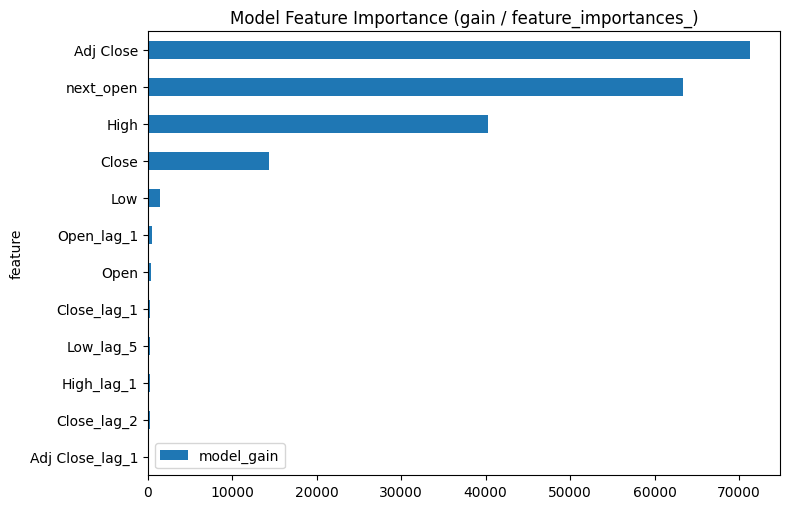

Running SHAP explainer (can be slow)...


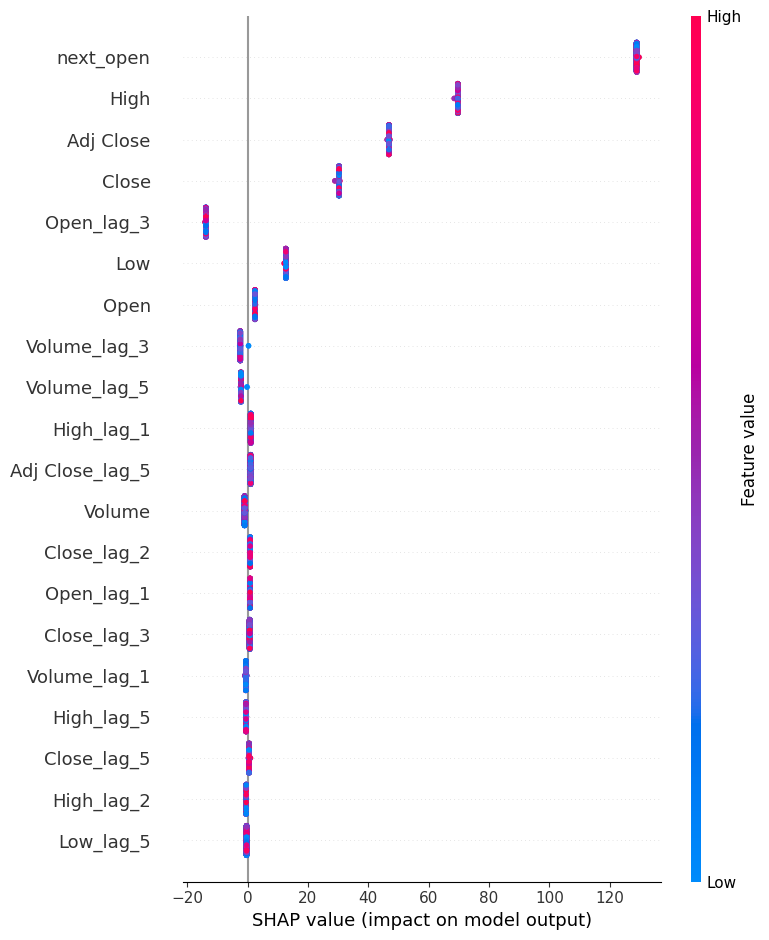

SHAP summary saved.


C:\Users\its_s\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:3063: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\its_s\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_function_base_impl.py:3064: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Computing permutation importance (this may take some seconds)...
Permutation importance failed: The 'estimator' parameter of permutation_importance must be an object implementing 'fit'. Got <__main__.BoosterWrapper object at 0x000002785F4B4EC0> instead.
Approximating PDPs (booster or non-sklearn model)...


<Figure size 1000x500 with 0 Axes>

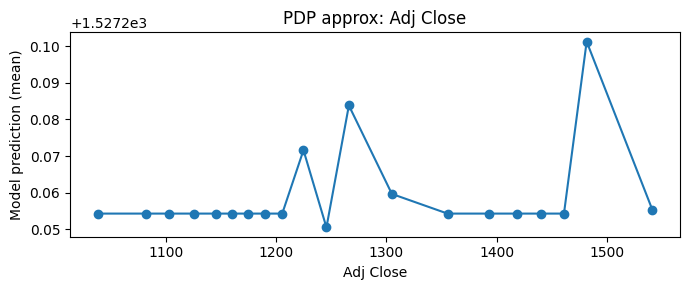

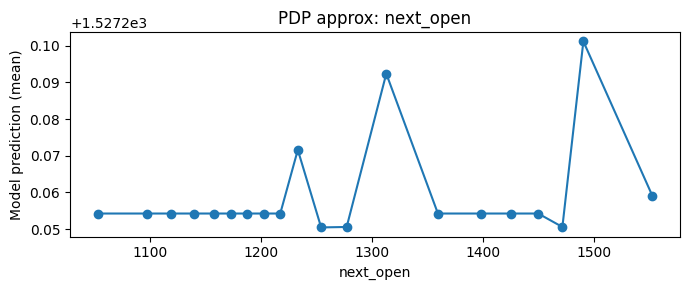

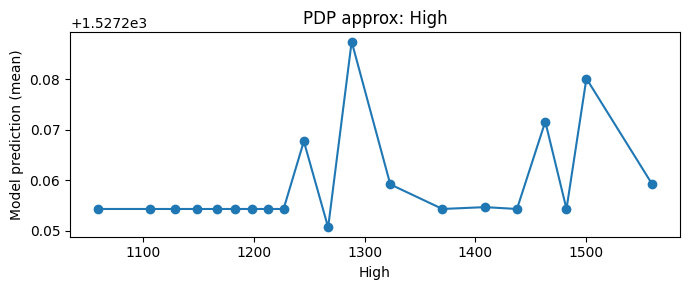

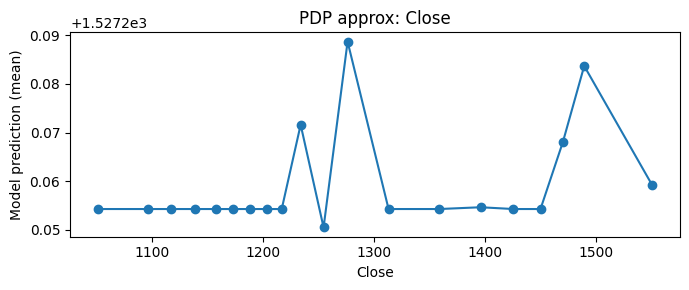

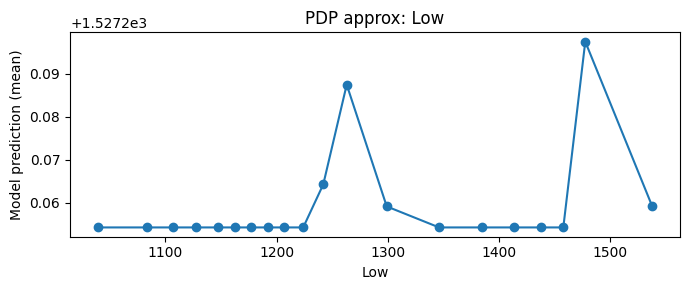

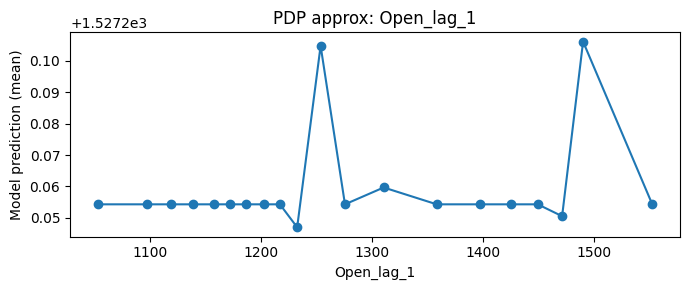

Explainability summary saved: models/next_close\explainability\explainability_summary.csv


,feature,model_gain
4,Adj Close,71295.140625
6,next_open,63402.914062
1,High,40300.550781
3,Close,14356.028320
2,Low,1431.009155
7,Open_lag_1,446.897064
0,Open,382.373169
11,Close_lag_1,281.226074
22,Low_lag_5,221.086258
15,High_lag_1,216.341537


Done. Files saved to: models/next_close\explainability


In [5]:
# Explainability: full ready-to-paste cell
# - Handles xgboost Booster with f0..fN keys by mapping to predictor names
# - Compatible RMSE (manual) to avoid sklearn 'squared' kwarg issues
# - SHAP optional (skips if not installed)
# - Computes permutation importance and PDP approximations
# - Saves outputs to models/next_close/explainability/

import os, glob, json, joblib
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,5)

# Optional libs
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False

from sklearn.inspection import permutation_importance, PartialDependenceDisplay

print("XGBoost available:", XGB_AVAILABLE, "SHAP available:", SHAP_AVAILABLE)

# -------------------------
# Config
# -------------------------
MODEL_DIR = "models/next_close"
FEATURES_CSV = "reliance_features.csv"   # engineered features file (must exist)
EXPLAIN_DIR = os.path.join(MODEL_DIR, "explainability")
os.makedirs(EXPLAIN_DIR, exist_ok=True)

SHAP_SAMPLE = 1000
PERMUTE_N_REPEATS = 10
TOP_K = 12

# -------------------------
# Load artifacts (predictors, scaler, model)
# -------------------------
def load_artifacts(model_dir: str):
    pred_json = next(iter(glob.glob(os.path.join(model_dir, "*_predictors.json"))), None)
    if pred_json is None:
        raise FileNotFoundError(f"No '*_predictors.json' found in {model_dir}. Run training to save predictors.")
    with open(pred_json, 'r') as f:
        predictors = json.load(f)

    scaler_file = next(iter(glob.glob(os.path.join(model_dir, "*_scaler.joblib"))), None)
    scaler = joblib.load(scaler_file) if scaler_file else None

    xgb_file = next(iter(glob.glob(os.path.join(model_dir, "*_xgb.json"))), None)
    joblib_file = next(iter(glob.glob(os.path.join(model_dir, "*_model.joblib"))), None)

    if xgb_file and XGB_AVAILABLE:
        booster = xgb.Booster()
        booster.load_model(xgb_file)
        model = booster
        model_type = "xgb_booster"
    elif joblib_file:
        model = joblib.load(joblib_file)
        model_type = "joblib"
    else:
        alt = next(iter(glob.glob(os.path.join(model_dir, "*.joblib"))), None)
        if alt:
            model = joblib.load(alt)
            model_type = "joblib"
        else:
            raise FileNotFoundError(f"No model file found in {model_dir}.")
    return predictors, scaler, model, model_type

predictors, scaler, model, model_type = load_artifacts(MODEL_DIR)
print("Loaded predictors count:", len(predictors), "model_type:", model_type)
print("Sample predictors:", predictors[:8])

# -------------------------
# Load features & align
# -------------------------
if not os.path.exists(FEATURES_CSV):
    raise FileNotFoundError(f"{FEATURES_CSV} not found. Run feature engineering to create it.")

df = pd.read_csv(FEATURES_CSV, parse_dates=["Date"] if "Date" in pd.read_csv(FEATURES_CSV, nrows=0).columns else None)
if "Date" in df.columns:
    df = df.sort_values("Date").reset_index(drop=True)

missing = [c for c in predictors if c not in df.columns]
if missing:
    raise SystemExit(f"Missing predictor columns in {FEATURES_CSV}: {missing[:30]} ... (run feature_engineering)")

X = df[predictors].copy()
y_close_next = df['next_close'].values if 'next_close' in df.columns else None

print("Loaded features rows:", len(X), "cols:", X.shape[1])
X_sample = X.sample(SHAP_SAMPLE, random_state=42) if len(X) > SHAP_SAMPLE else X.copy()

# -------------------------
# Model predict wrapper
# -------------------------
def model_predict_rows(X_arr: np.ndarray):
    """Return 1d numpy predictions for X_arr rows. Works for Booster or sklearn models."""
    if model_type == "xgb_booster":
        d = xgb.DMatrix(X_arr, feature_names=predictors)
        preds = model.predict(d)
        return np.array(preds).ravel()
    else:
        preds = model.predict(X_arr)
        return np.array(preds).ravel()

# quick RMSE (manual) if we have stored next_close
if y_close_next is not None:
    preds_all = model_predict_rows(X.values)
    mse = float(np.mean((np.array(y_close_next) - np.array(preds_all))**2))
    rmse = float(np.sqrt(mse))
    print("RMSE on next_close (model predictions vs stored next_close):", round(rmse, 6))

# -------------------------
# 1) Model feature importance (fixed mapping)
# -------------------------
try:
    if model_type == "xgb_booster":
        raw = model.get_score(importance_type='gain') or {}
        # diagnostic: show a few raw keys
        print("Sample raw importance keys (first 10):", list(raw.items())[:10])
        # map f{idx} -> predictor name when needed
        mapped = {}
        for k, v in raw.items():
            if isinstance(k, str) and k.startswith('f') and k[1:].isdigit():
                idx = int(k[1:])
                if 0 <= idx < len(predictors):
                    mapped[predictors[idx]] = v
                else:
                    mapped[k] = v
            else:
                mapped[k] = v
        imp_df = pd.DataFrame({
            'feature': list(predictors),
            'model_gain': [float(mapped.get(f, 0.0)) for f in predictors]
        }).sort_values('model_gain', ascending=False)
    else:
        if hasattr(model, "feature_importances_"):
            imp_df = pd.DataFrame({'feature': list(predictors), 'model_gain': list(model.feature_importances_)}).sort_values('model_gain', ascending=False)
        else:
            imp_df = pd.DataFrame({'feature': predictors, 'model_gain': [0.0]*len(predictors)})
    imp_df.to_csv(os.path.join(EXPLAIN_DIR, "feature_importance_model.csv"), index=False)
    display(imp_df.head(TOP_K))
    fig, ax = plt.subplots(figsize=(8, TOP_K*0.35+1))
    imp_df.head(TOP_K).plot.barh(x='feature', y='model_gain', ax=ax)
    ax.invert_yaxis()
    ax.set_title("Model Feature Importance (gain / feature_importances_)")
    plt.tight_layout()
    fig.savefig(os.path.join(EXPLAIN_DIR, "model_feature_importance.png"), dpi=150)
    plt.show()
except Exception as e:
    print("Failed to compute model feature importance:", e)

# -------------------------
# 2) SHAP (optional)
# -------------------------
if SHAP_AVAILABLE:
    try:
        print("Running SHAP explainer (can be slow)...")
        if model_type == "xgb_booster":
            explainer = shap.TreeExplainer(model)
            # shap may return arrays or list; using sample
            shap_values = explainer.shap_values(X_sample, check_additivity=False)
        else:
            try:
                explainer = shap.TreeExplainer(model)
                shap_values = explainer.shap_values(X_sample)
            except Exception:
                background = shap.sample(X, min(100, len(X)), random_state=42)
                explainer = shap.KernelExplainer(lambda z: model_predict_rows(z), background)
                shap_values = explainer.shap_values(X_sample, nsamples=100)
        np.savez_compressed(os.path.join(EXPLAIN_DIR, "shap_sample_values.npz"), values=np.array(shap_values))
        plt.figure(figsize=(8,6))
        try:
            shap.summary_plot(shap_values, X_sample, show=True)
        except Exception:
            if isinstance(shap_values, list):
                shap.summary_plot(shap_values[0], X_sample, show=True)
        plt.tight_layout()
        plt.savefig(os.path.join(EXPLAIN_DIR, "shap_summary.png"), dpi=150, bbox_inches='tight')
        print("SHAP summary saved.")
        top_feats = imp_df['feature'].head(6).tolist()
        for f in top_feats:
            try:
                shap.dependence_plot(f, shap_values, X_sample, show=False)
                plt.tight_layout()
                plt.savefig(os.path.join(EXPLAIN_DIR, f"shap_dependence_{f}.png"), dpi=150, bbox_inches='tight')
                plt.close()
            except Exception as ex:
                print("Failed SHAP dependence for", f, ex)
    except Exception as e:
        print("SHAP explainer error:", e)
else:
    print("SHAP not installed — skipping SHAP steps. To enable install: pip install shap")

# -------------------------
# 3) Permutation importance
# -------------------------
try:
    print("Computing permutation importance (this may take some seconds)...")
    X_perm = X_sample.copy()
    if y_close_next is not None:
        y_perm = df.loc[X_perm.index, 'next_close'].values
    else:
        y_perm = model_predict_rows(X_perm.values)

    if model_type == "xgb_booster":
        # create simple wrapper with predict method for sklearn permutation_importance
        class BoosterWrapper:
            def __init__(self, booster, predict_cols):
                self.booster = booster
                self.predict = lambda X_in: np.array(booster.predict(xgb.DMatrix(X_in, feature_names=predict_cols))).ravel()
        est = BoosterWrapper(model, predictors)
    else:
        est = model

    perm = permutation_importance(est, X_perm.values, y_perm, n_repeats=PERMUTE_N_REPEATS, random_state=42, n_jobs=1)
    perm_df = pd.DataFrame({
        'feature': X_perm.columns,
        'perm_mean': perm.importances_mean,
        'perm_std': perm.importances_std
    }).sort_values('perm_mean', ascending=False)
    perm_df.to_csv(os.path.join(EXPLAIN_DIR, "permutation_importance.csv"), index=False)
    display(perm_df.head(TOP_K))
    fig, ax = plt.subplots(figsize=(8, TOP_K*0.35+1))
    perm_df.head(TOP_K).plot.barh(x='feature', y='perm_mean', ax=ax)
    ax.invert_yaxis()
    ax.set_title("Permutation Importance (mean decrease)")
    plt.tight_layout()
    fig.savefig(os.path.join(EXPLAIN_DIR, "permutation_importance.png"), dpi=150)
    plt.show()
except Exception as e:
    print("Permutation importance failed:", e)

# -------------------------
# 4) PDP-like approximations for top features
# -------------------------
try:
    top_features = perm_df['feature'].head(6).tolist() if 'perm_df' in globals() else imp_df['feature'].head(6).tolist()
    if model_type != "xgb_booster" and hasattr(model, "predict"):
        print("Using sklearn PDP for top features:", top_features)
        fig, axes = plt.subplots(len(top_features), 1, figsize=(8, 3*len(top_features)))
        for i, feat in enumerate(top_features):
            PartialDependenceDisplay.from_estimator(model, X, [feat], ax=axes[i], grid_resolution=20)
            axes[i].set_ylabel(feat)
        plt.tight_layout()
        plt.savefig(os.path.join(EXPLAIN_DIR, "partial_dependence.png"), dpi=150)
        plt.show()
    else:
        print("Approximating PDPs (booster or non-sklearn model)...")
        for feat in top_features:
            s = X[feat]
            bins = np.quantile(s, np.linspace(0,1,21))
            mids = (bins[:-1] + bins[1:]) / 2.0
            preds_mean = []
            for a, b in zip(bins[:-1], bins[1:]):
                ix = (s >= a) & (s <= b)
                if ix.sum() == 0:
                    preds_mean.append(np.nan)
                else:
                    preds_mean.append(model_predict_rows(X.loc[ix, :].values).mean())
            fig, ax = plt.subplots(figsize=(7,3))
            ax.plot(mids, preds_mean, marker='o')
            ax.set_title(f"PDP approx: {feat}")
            ax.set_xlabel(feat)
            ax.set_ylabel("Model prediction (mean)")
            plt.tight_layout()
            fig.savefig(os.path.join(EXPLAIN_DIR, f"pdp_approx_{feat}.png"), dpi=150)
            plt.show()
except Exception as e:
    print("Partial dependence / PDP approximation failed:", e)

# -------------------------
# 5) Save merged explainability CSV
# -------------------------
try:
    imp_summary = imp_df.copy().rename(columns={'model_gain':'model_gain'})
    if 'perm_df' in globals():
        merged_imp = imp_summary.merge(perm_df[['feature','perm_mean']], on='feature', how='left').rename(columns={'perm_mean':'perm_mean'})
    else:
        merged_imp = imp_summary
    merged_imp.to_csv(os.path.join(EXPLAIN_DIR, "explainability_summary.csv"), index=False)
    print("Explainability summary saved:", os.path.join(EXPLAIN_DIR, "explainability_summary.csv"))
    display(merged_imp.head(20))
except Exception as e:
    print("Failed to save explainability summary:", e)

print("Done. Files saved to:", EXPLAIN_DIR)
